# 한국어 데이터로 챗봇 만들기!!!

이제까지 영어로 만들었던 챗봇을 이번에는 한국어 데이터로 바꾸는 실전 프로젝트를 하게 되었다!!!

우선 주요 라이브러리 버전부터 확인~~

In [120]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.2


# Step 1. 데이터 수집하기!!

한국어 챗봇 데이터는 송영숙님께서 공개한 챗봇 데이터를 사용한다.

이 데이터는 아래의 링크에서 다운 가능하다.

데이터셋 다운로드 링크 : https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

주피터 노트북에서 할려면 cloud shell에서 아래 명령어를 입력하면 된다!!

```
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

참고로 전 코랩에서 할 것이라서 해당 명령어를 통해 클라우드 주퍼터에 옮겨진 데이터를 다운받아 코랩 연동을 통해 코랩으로 불러올 것이다.

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
data_path = '/content/drive/MyDrive/AIFFEL/DATASET/Ex14/ChatbotData.csv'
data = pd.read_csv(data_path)
print(data.shape)
data.head(10)

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


# Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터라서 영어 데이터에 사용했던 전처리와 일부 동일한 전처리를 거친 후 또 다른 전처리를 거쳐야만 한다. 우선 결측치부터 확인~~

In [123]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

결측치는 없는 걸로 판명났고, 이제 **구두점(punctuation)**을 제거하는 **정규 표현식(Regular Expression)**을 사용한다. 단어를 토크나이징(tokenizing)을 하는 데 방해가 되지 않도록 정제하는 것이 목표라는 점~~

In [124]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이에 거리를 만든다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이~~
  # 즉, student와 온점 사이에 거리를 만들어 떼어 놓는다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  
  # 구두점을 제외한 나머지 특수문자들은 공백인 ' '로 대체한다.
  # 한글 자모음으로 만들 수 있는 모든 문자, 숫자, 알파벳, 구두점은 살린다.
  sentence = re.sub(r"[^0-9a-zA-Z가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [125]:
data['Q'] = data['Q'].apply(lambda x : preprocess_sentence(x))
data['A'] = data['A'].apply(lambda x : preprocess_sentence(x))

In [126]:
data.head(10)

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,ppl 심하네,눈살이 찌푸려지죠 .,0
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요 .,0
6,sd카드 안돼,다시 새로 사는 게 마음 편해요 .,0
7,sns 맞팔 왜 안하지,잘 모르고 있을 수도 있어요 .,0
8,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .,0
9,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .,0


단, 실험적인 측면에서 알파벳과 숫자는 조금 살려봤다.
실험을 해서 에러가 뜬다면 그 부분에 대한 전처리는 따로 해 보겠다.

전처리는 잘 된 것을 확인할 수 있었다. 저는 Q와 A만을 남겨도 무방하다고 판단하여 라벨은 drop하기로 했다.

In [127]:
data.drop('label', axis=1, inplace=True)
data.head(10)

,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,ppl 심하네,눈살이 찌푸려지죠 .
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요 .
6,sd카드 안돼,다시 새로 사는 게 마음 편해요 .
7,sns 맞팔 왜 안하지,잘 모르고 있을 수도 있어요 .
8,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .
9,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .


In [128]:
# 질문, 답변 리스트 생성
questions = list(data['Q'])
answers = list(data['A'])

# Step 3. SubwordTextEncoder 사용

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있다만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용하게 될 것이다.

## (1) 단어 집합 형성

In [129]:
# 질문과 답변 데이터에 대해 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [130]:
print(tokenizer.subwords[:20])

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_', '이_', ' . ', '을_', '잘_', '도_', '고_', '요', '것_', '많이_', '안_']


`tokenizer.subwords`를 통해 토큰화된 서브워드를 확인했고, 원래 문장과 정수 인코딩 진행한 결과를 확인해 볼 수 있었다.

단어 집합을 생성하고 보니, seq2seq 챕터에서 배웠던 것처럼 인코더-디코더 모델 계열에는 디코더의 입력으로 사용할 시작을 의미하는 시작 토큰 SOS와 종료 토큰 EOS 또한 존재한다. 해당 토큰들도 단어 집합에 포함시킬 필요가 있기 때문에 이 두 토큰에 정수값을 부여해 준다.

In [131]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size],[tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 +2로 늘려줌
VOCAB_SIZE = tokenizer.vocab_size + 2

시작 토큰과 종료 토큰을 추가해 주었으나, 단어 집합의 크기도 +2로 해준다.  
시작 토큰의 번호와 종료 토큰의 번호, 그리고 단어 집합의 크기도 출력해서 확인해본다.

In [132]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8162]
종료 토큰 번호 : [8163]
단어 집합의 크기 : 8164


## (2) 정수 인코딩과 패딩

단어 집합을 생성한 후 SubwordTextEncoder의 토크나이저로 정수 인코딩을 진행할 수 있다. 이는 토크나이저의 `encode()`를 사용하면 된다. 우선 임의로 선택한 20번 질문의 샘플, 즉 `questions[20]`을 가지고 정수 인코딩을 진행한다.

In [133]:
# SubwordTextEncoder 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[40])))

임의의 질문 샘플을 정수 인코딩 : [7861, 1715, 319, 4878]


임의의 질문 문장이 정수 시퀀스로 변한이 되었다. 반대로 정수 인코딩 된 결과는 다시 `decode()`를 사용해 기존의 텍스트 시퀀스로 복원할 수 있다. 40번 질문 샘플을 가지고 정수 인코딩하고, 다시 이를 디코딩하는 과정은 다음과 같다.

In [134]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[40]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [7861, 1715, 319, 4878]
기존 문장: 간만에 떨리니까 좋더라


정수 인코딩된 문장을 `decode()`를 하면 자동으로 서브워드들까지 다시 붙여서 기존 단어로 복원해 준다. 가령, 정수 인코딩 문장을 보면 정수가 4개인데 기존 문장의 띄어쓰기 단위인 어절은 3개밖에 존재하지 않는다. 이는 한 어절이 정수 인코딩 후에는 두 개 이상의 정수일 수 있다는 것을 의미한다.

In [135]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

7861 ----> 간만에 
1715 ----> 떨리
319 ----> 니까 
4878 ----> 좋더라


실제로 '떨리니까'라는 한 어절이 1715, 319라는 두 개의 정수로 인코딩이 되어 있는 걸 확인할 수 있었다. 이렇게 샘플 하나에 대해 정수 인코딩과 디코딩을 해 봐서 그 결과를 확인해 봤으면, 이번에는 전체 데이터에 대해서도 인코딩과 디코딩을 해 주어야 하겠죠?


이를 위한 함수로 tokenize_and_filter()를 사용할 것이다. 
그리고 최대 패딩 길이를 정하기 전에 해당 데이터셋의 질문 문장 답변 문장의 최대 길이를 각각 구해보고 개략적으로 패딩 길이를 정하기로 했다.

In [136]:
# 질문 데이터 길이
q_word_len = [len(x) for x in questions]

# 답변 데이터 길이
a_word_len = [len(x) for x in answers]

# 질문과 답변의 최대 길이를 각각 뽑아보기
print(f'질문의 최대 길이 : {max(q_word_len)} \n답변 최대 길이 : {max(a_word_len)}')

질문의 최대 길이 : 57 
답변 최대 길이 : 78


질문의 최대 길이와 답변의 최대 길이를 보고 대강 패딩 길이를 얼추 60 정도로 맞추면 될 거 같다!!

In [137]:
# 최대 길이를 60으로 정의
MAX_LENGTH = 60

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [138]:
questions, answers = tokenize_and_filter(questions, answers)

정수 인코딩과 패딩이 진행된 후의 데이터 크기를 확인해 보면!!

In [139]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 60)
답변 데이터의 크기(shape) : (11823, 60)


이상없이 모든 문장의 최대 길이는 60으로 고정되었음을 알 수 있다!!!

설정한 최대 문장 길이보다 짧은 문장들은 0으로 채움으로써 패딩이 되었을 것이고, 반대로 긴 문장들은 뒷부분을 짤려나갔을 것이다!!!

임의로 100번 샘플을 출력해 보면~~

In [140]:
# 100번 샘플을 임의로 출력
print(questions[100])
print(answers[100])

[8162 1939  459 8163    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[8162  500 6963 7938  689 2446   49 8163    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


다음으로, 질문과 답변의 쌍을 `tf.data.Dataset` API의 입력으로 사용하여 파이프라인을 구성한다. 이 때 교사 강요를 위해서 `answer[:,:-1]`디코더의 입력값, `answer[:,1:]`을 디코더의 레이블로 사용한다.

In [141]:
# 텐서플로우 dataset을 이용해 shuffle을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요를 사용하기 위해 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 11823

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs' : questions,
     'dec_inputs' : answers[:,:-1]},   # 디코더의 입력. 마지막 패딩 토큰 제거
     {'outputs': answers[:, 1:]},        # 맨 처음 토큰(시작 토큰) 제거.    
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [142]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지를 확인
print(answers[0])    # 기존 샘플
print(answers[:1][:, :-1])   # 마지막 패딩 토큰이 제거되면서 길이가 59로 바뀜
print(answers[:1][:, 1:])    # 맨 처음 토큰(시작 토큰) 제거되면서 역시 길이가 59로 바뀜

[8162 3837   74 7880    1 8163    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[[8162 3837   74 7880    1 8163    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
[[3837   74 7880    1 8163    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]


# Step 4. 모델 구성하기

이제 트랜스포머를 본격적으로 만드는 시간이다!! 지금까지 밟아왔던 과정을 토대로 진행하면 된다.


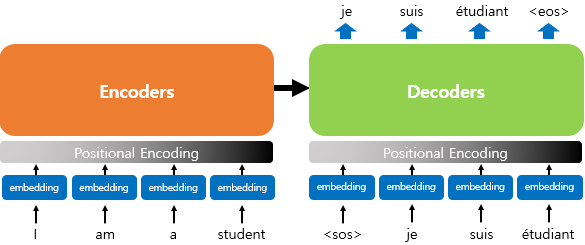

## (1) 포지셔널 인코딩 레이어
먼저 포지셔널 인코딩 레이어부터 짠다.  

많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거친다. 트랜스포머 또한 그 점에서 다른 모델들과 크게 다르지 않다. 하지만 트랜스포머 모델의 입력 데이터 처리에는 RNN 계열의 모델들과 다른 점이 있는데, 바로 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점이다. 그 값은 바로 위 그림에서의 포지셔널 인코딩에 해당하는 부분이다.


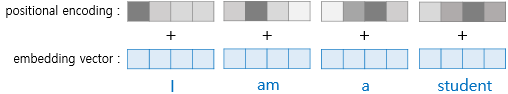

이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문에 트랜스포머가 RNN과 결정적으로 다른 점이라고 할 수 있다. RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순을 알려줄 필요가 없다. 그러나 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ast I'를 구분할 수 없을 수도 있다. 그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터값을 더해서 모델의 입력으로 삼는 것이다!!!

In [143]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## (2) 어텐션? 어텐션!
트랜스포머 인코더와 디코더에서 사용하고 있는 개념인 어텐션에 대해 알아보자!

어텐션이란?
어텐션 메컨즘을 그림으로 표현한다면 아래와 같이 표현할 수 있을 거 같다.

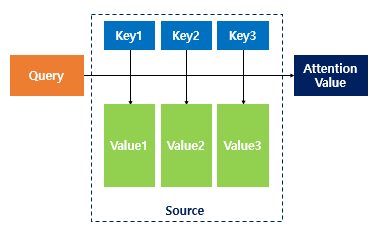

어텐션 함수는 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키와 맵핑되어 있는 각각의 값에 반영해준다. 그리고 유사도가 반영된 값을 모두 더해 뭉쳐주면 이게 최종 결과인 어텐션 값이 된다.

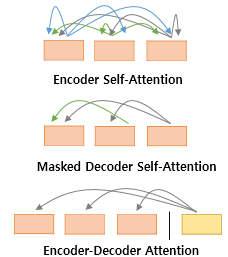

* 첫 번째 그림 : 인코더 셀프 어텐션은 인코더에서 이루어짐을 나타냄.
* 두 번째 그림 : 디코더 셀프 어텐션은 디코더에서 이루어짐을 나타냄.
* 세 번째 그림 : 인코더-디코더 어텐션 역시 디코더에서 이루어짐을 나타냄.

In [144]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [145]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# (3) 마스킹

두 정수 시퀀스에 대해서 각각 결과가 출력될텐데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고, 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다. 어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있다.

In [146]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법이다.

이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 한다.

In [147]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


## (4) 인코더 설계

트랜스포머의 입력, 그리고 트랜스포머 내부에서 일어나는 어텐션에 대해서도 정리했으니, 이제는 인코더 층을 구현할 차례이다.

하나의 인코더 층은 크게 두 개의 서브 층(sublayer)으로 나뉜다. 바로 셀프 어텐션과 피드 포워드 신경망이다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어진다.

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수를 구현해보자.

In [148]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 층을 쌓아 인코더 만들기

이렇게 구현한 인코더 층을 임베딩 층과 포지셔널 인코딩을 연결하고 사용자가 원하는 만큼의 인코더 층을 쌓음으로써 트랜스포머의 인코더를 완성할 수 있다.

In [149]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## (5) 디코더 설계

디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡하다. 인코더는 두 개의 서브 층으로 구성되지만 디코더는 세 개의 서브 층으로 구성된다.(하나의 서브 층이 더 추가됨)

첫 번째는 **셀프 어텐션**, 두 번째는 **인코더-디코더 어텐션**, 세 번째는 **피드 포워드 신경망**이다. 특히 인코더-디코더 어텐션의 경우 셀프 어텐션과는 달리 Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다.

In [150]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 디코더 층을 쌓아 디코더 만들기

이렇게 구현한 디코더의 층은 임베딩 층과 포지셔널 인코딩을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다. 인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓는다.

In [151]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# (6) 모델 정의 및 학습하기

In [152]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## (7) 모델 생성

하이퍼 파라미터를 조정해 실제 논문의 트랜스포머보다는 작은 모델을 만들 것이다.

여기서 설정한 주요 하이퍼파라미터는 다음과 같다.   
* D_MODEL : 인코더와 디코더 내부의 입, 출력의 고정 차원
* NUM_LAYERS : 인코더와 디코더 층의 개수
* NUM_HEADS : 멀티 헤드 어텐션에서의 헤드 수
* UNITS : 피드 포워드 신경망의 은닉층의 크기
* DROPOUT : 드롭아웃 하고자 하는 비율

In [170]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
UNITS = 256
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    units=UNITS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    2881536     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### 손실 함수

레이블인 시퀀스에 패딩이 있으므로, loss를 계산할 때 패딩 마스크를 적용할 것

In [171]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀된 학습률

모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮춰 가면서 안정적으로 수렴하게 되는 고급 기법을 널리 사용하고 있는데, 이런 방법을 커스텀 학습률 스케줄링(Custom Learning Scheduling)이라고 한다.

논문에 나와있는 공식을 토대로 커스텀 학습률 스케줄러를 적용한다. 아담 옵티마이저를 채택했다.

$lrate = d_{model}^{-0.5}⋅min(step\_num^{-0.5},step\_num⋅warmup\_steps^{-1.5})$

In [172]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 모델 컴파일

In [173]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [174]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 20s 69ms/step - loss: 0.9660 - accuracy: 0.0155
Epoch 2/50
185/185 [==============================] - 13s 69ms/step - loss: 0.7828 - accuracy: 0.0326
Epoch 3/50
185/185 [==============================] - 13s 69ms/step - loss: 0.6673 - accuracy: 0.0333
Epoch 4/50
185/185 [==============================] - 13s 69ms/step - loss: 0.6154 - accuracy: 0.0357
Epoch 5/50
185/185 [==============================] - 13s 69ms/step - loss: 0.5763 - accuracy: 0.0381
Epoch 6/50
185/185 [==============================] - 13s 71ms/step - loss: 0.5365 - accuracy: 0.0408
Epoch 7/50
185/185 [==============================] - 13s 69ms/step - loss: 0.4933 - accuracy: 0.0446
Epoch 8/50
185/185 [==============================] - 13s 69ms/step - loss: 0.4454 - accuracy: 0.0498
Epoch 9/50
185/185 [==============================] - 14s 73ms/step - loss: 0.3932 - accuracy: 0.0554
Epoch 10/50
185/185 [==============================] - 13s 69ms/step - loss: 0.338

# Step 5. 모델 평가하기!

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만드는 과정이다.  
예측 단계는 기본적으로 다음과 같은 과정을 거친다!!

* 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.

* 입력 문장을 토크나이징하고,` START_TOKE N`과 `END_TOKEN`을 추가한다.

* 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.

* 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.

* 디코더는 예측된 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.

* `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [175]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30   5 1059   7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
  
  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복한다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가된다.
    # 이 output_sequence는 다시 디코더의 입력이 된다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수도 만들어 준다.

In [176]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

임의의 문장으로부터 챗봇의 대답을 얻어보면~~

In [177]:
sentence_generation('식사 맛있게 하세요!')

입력 : 식사 맛있게 하세요!
출력 : 저는 생각보다 많아요 .


'저는 생각보다 많아요 .'

In [178]:
sentence_generation('취미가 뭐예요?')

입력 : 취미가 뭐예요?
출력 : 그래도 상관없어요 .


'그래도 상관없어요 .'

In [179]:
sentence_generation('오늘은 왜 결석했나요?')

입력 : 오늘은 왜 결석했나요?
출력 : 건 그럴 거예요 .


'건 그럴 거예요 .'

In [180]:
sentence_generation('퇴근해 보겠습니다.')

입력 : 퇴근해 보겠습니다.
출력 : 학교 다닐 때가 좋은 거예요 .


'학교 다닐 때가 좋은 거예요 .'

In [181]:
sentence_generation('추석 연휴 잘 지내시기 바랍니다!')

입력 : 추석 연휴 잘 지내시기 바랍니다!
출력 : 썸은 짧은 게 좋습니다 .


'썸은 짧은 게 좋습니다 .'

In [182]:
sentence_generation('오늘은 뭐 할 거예요?')

입력 : 오늘은 뭐 할 거예요?
출력 : 그건 절대 아닐 거예요 .


'그건 절대 아닐 거예요 .'

In [183]:
# 이거 알아들은 거 조금 신선한 충격!!!
sentence_generation('아 오늘 버스 퍼져서 지각한거 킹받네!!')

입력 : 아 오늘 버스 퍼져서 지각한거 킹받네!!
출력 : 다음에는 픽서를 사용해보세요 .


'다음에는 픽서를 사용해보세요 .'

In [184]:
sentence_generation('맛점하세요!')

입력 : 맛점하세요!
출력 : 축하합니다 !


'축하합니다 !'

In [185]:
sentence_generation('방가방가, 방학 잘 보냄?')

입력 : 방가방가, 방학 잘 보냄?
출력 : 기분이 조금이나마 나아졌길 바랍니다 .


'기분이 조금이나마 나아졌길 바랍니다 .'

In [186]:
sentence_generation('니 여친 완죤 존예네!')

입력 : 니 여친 완죤 존예네!
출력 : 자신을 우선순위로 해주세요 .


'자신을 우선순위로 해주세요 .'

# ✍ 결과 분석

<1차>   
D_MODEL = 256  
NUM_LAYERS = 2  
NUM_HEADS = 8  
UNITS = 512  
DROPOUT = 0.1  
EPOCHS = 30  

|순번|Q|A|
|:------|:------|:------:|
|1| 식사 맛있게 하세요!|당신 그대로의 모습이 보기 좋아요 .|
|2| 취미가 뭐예요?|일 핑계로 연락해봐요 .|
|3| 오늘은 왜 결석했나요?|그럴 수도 있어요 .|
|4| 퇴근해 보겠습니다.|째깍 .|
|5| 추석 연휴 잘 지내시기 바랍니다!|시간적 여유가 생겨서 그런가봐요 .|
|6| 오늘은 뭐 할 거예요?|그건 좀 힘들 때 도와주세요 .|
|7| 아 오늘 버스 퍼져서 지각한거 킹받네!!|시간은 핑계예요 .|
|8| 맛점하세요!|모든 일이 뜻대로 흘러가진 않나봐요 .|
|9| 방가방가, 방학 잘 보냄?|핸드폰은 핸드폰 가게에서 바꾸세요 .|
|10| 니 여친 완죤 존예네!|대화를 이유가 없다면 서운함을 전해보세요 .|

* 순번 7번의 Q&A의 경우 화가 났다는 뜻의 약간 신조어 격인 킹받다라는 단어를 썼는데, 이게 알아들은 건지 '시간은 핑계예요'라는 그럴 듯한 답변이 나와서 제법 놀랐다!!
* 그러나 나머지의 경우는 약간 문맥상 적절한 답안이 나오지는 못한 것 같아서 아쉬웠다!!


<2차>   
D_MODEL = 256  
NUM_LAYERS = 2  
NUM_HEADS = 8  
UNITS = 256  
DROPOUT = 0.1  
EPOCHS = 50 

|순번|Q|A|
|:------|:------|:------:|
|1| 식사 맛있게 하세요!|그래도 상관없어요 . 칭찬해주고 싶네요 .|
|2| 취미가 뭐예요?|그래도 취미 생활이 있어야 사는 재미가 있죠 .|
|3| 오늘은 왜 결석했나요?|최선을 다한 건 좋은 거예요 .|
|4| 퇴근해 보겠습니다.|째깍째깍 .|
|5| 추석 연휴 잘 지내시기 바랍니다!|썸 타기 좋은 계절이에요 .|
|6| 오늘은 뭐 할 거예요?|그건 절대 아닐 거예요 .|
|7| 아 오늘 버스 퍼져서 지각한거 킹받네!!|의미심장한 메세지가 어떨까요 .|
|8| 맛점하세요!|좋아요 !|
|9| 방가방가, 방학 잘 보냄?|맛있는 거 드세요 .|
|10| 니 여친 완죤 존예네!|축하드려요 !|

* 다른 건 별로 안 건드리고 1차 때보다 에포크만 조금 더 줘 봤는데 아까보다는 확실히 문맥이 통하는 Q&A 세트가 좀 나온 거 같았다.
* 특히 8번의 '맛점하세요'랑 10번 '니 여친 완죤 존예네!' 처럼 요새 사람들이 자주 쓰는 줄임말로 표현했는데도 제법 적절한 답이 툭 튀어나온 거 같아서 나름 뿌듯했다. 시간이 없어서 에포크를 더 못 늘려 보겠지만 에포크를 늘린 게 조금은 학습에 도움이 되는 걸 느낄 수 있었다.

# ✍  루브릭
|평가문항|상세기준|결과체크|
|:------|:------:|------:|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|○|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|○|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.|○|

그냥 하나라도 맥락에 맞는 한국어 답변을 리턴했다고 보고 1번, 2번, 3번 전 항목에 대해 다 ○를 주었다. 

# ✍ 회고

* 일단 이번 노드의 경우는 개념 자체가 범접할 수 없는 난이도였던 거 같다!! 그래도 나름 재미있는 노드라는 생각이 들었다!!

* 왜냐하면 챗봇을 만들기 위한 모델 구현 과정부터 챗봇이 맥락상 적절한 답변을 하도록 평가하고 수정하는 과정까지 굉장히 많은 과정을 밟아왔기 때문인데, 하고 나서 느낀 점은 이 어려운 과정을 해냈다고 생각하니 나 자신이 너무 대견하고 뿌듯하다는 것이다!! CV를 하기로 결심했음에도 NLP 쪽에서 이런 다양한 시도를 해 볼 수 있다는 게 어디 쉬운 결심인가!!!

* 모델을 설계하고 입력값(질문 문장)을 다양하게 줘 봤다. 심지어 존예라든지 맛점이라든지 킹받는다든지... 이런 요새 사람들이 자주 쓰는 준말이나 신조어도 입력을 해 봤다는 것이다. 이런 시도 자체를 해 봤다는 게 다시 생각해 봐도 대단한 거 같다. 심지어 적절한 답변이 제대로 나온 것도 몇 개 존재했던 거 같아서 더 그런 느낌이 들었는지도 ㅎㅎ.

* EPOCH는 시간상 50회까지만 돌려보는 데 그쳤지만 모델 설계의 기본 뼈대를 알았기 때문에 CV를 가게 되더라도 모델 설계를 함에 있어 하이퍼 파라미터를 어떻게 조작하면 될지를 이제 조금을 알 수 있게 되지 않았나 하며 이번 노드도 무사히 완료!!!

대화형 챗봇 참조 블로그 링크 : 
https://wikidocs.net/89786